# Emulated Hand Controller

## By Haris Naveed, Jash Narwani, and Robert Walsh

For this project our goal is to create a hand tracking and gesture recognition system in such a way that the gestures could be used as a replacement for a simple game controller.
In this case we intend to target and demonstrate the functionality as an NES for our controller input

## Step 1: Hand Tracking

In order to do anything for this project, we first need a method to track our hands. We can do this by making use of the mediapipe and openCV packages

### What is Mediapipe?
Mediapipe is an open-source package developed by Google that contains a series of pre-made models or functions with aiding training of models.
In our case, we will be using the pre-trained Hands() model to help us with object detection. While it is true that the Hands model can detect gestures on its own, we elected to separate the act of object detection and gesture recognition into their own models. For our purposes, we will be using Hands() solely for finding our hands in a frame.

In [1]:
import time

# here's our initial packages
# NOTE: To use mediapipe in a notebook you need to install a package "msvc-runtime". Otherwise you will run into DLL errors
import cv2
import mediapipe as mp

import copy

import matplotlib.pyplot as plt

In [2]:
# Before we get started proper, we should start by defining our hand detection model.
# Thankfully, mediapipe has a premade model specifically for finding and tracking hands
hands = mp.solutions.hands.Hands()

In [3]:
# we need to also define our cv2 capturing method. Without it, we won't be able to track our hands at all. I hope you have a camera somewhere on your computer...
# if not, you can make use of the example dataset in the cells that call for it
def videoCapture():
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("No camera, that sucks")
        return None
    
    return cap

def endCapture(cap):
    cap.release()
    
    cv2.destroyAllWindows()

In [4]:
# use this to identify our hands
def findHand(frame, margin, hands, convert=True):
    # mediapipe uses RGB to find hands, cv2 captures BGR for some reason
    # we correct this
    
    if convert:
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        img = frame

    # use the mediapipe hands model to identify our hand and keypoints
    results = hands.process(img)
    cutFrame = None

    # mediapipe normalizes coordinates, use capture size to fix that for later
    h, w, c = frame.shape

    # if a hand is identified...
    if results.multi_hand_landmarks:
        # get the landmarks of the first hand
        hand1 = results.multi_hand_landmarks[0]
        Xs = []
        Ys = []
        # denormalize the coordinates of each landmark
        for landmark in hand1.landmark:
            cx, cy = int(landmark.x * w), int(landmark.y * h)
            Xs.append(cx)
            Ys.append(cy)

        # identify the bounds of our hand
        xmin = min(Xs)
        xmax = max(Xs)
        ymin = min(Ys)
        ymax = max(Ys)

        # crop the frame to only have our hand
        cutFrame = copy.deepcopy(frame[max(0, ymin-margin):min(frame.shape[0], ymax+margin), max(0, xmin-margin):min(frame.shape[1], xmax+margin)])
        
        # also draw a rectangle in the original image, just so you can see it working in another way
        cv2.rectangle(frame, (max(0, xmin-margin), max(0, ymin-margin)), (min(frame.shape[1], xmax+margin), min(frame.shape[0], ymax+margin)), (0, 255, 0), 2)

    # return the frame, and the cropped frame (if applicable)
    return frame, cutFrame

Let's give it a try. Try running the next cell with your hand in clear view of the camera

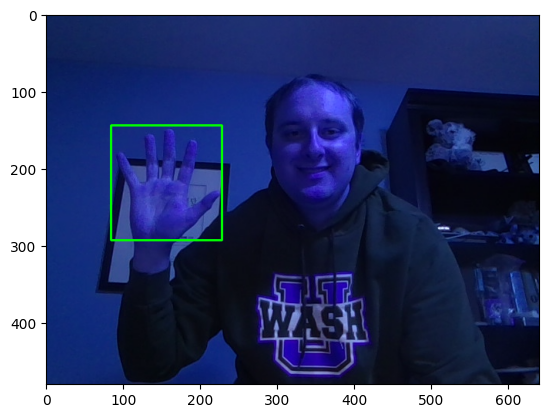

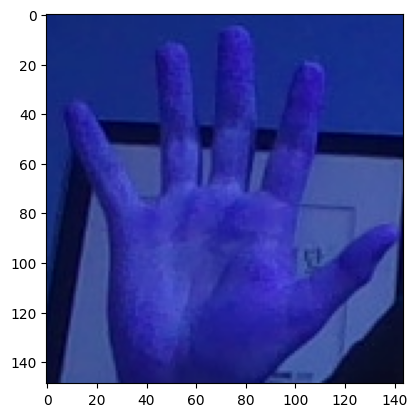

In [5]:
cap = videoCapture()

ret, frame = cap.read()

# Find the hand and get the cropped frame
frame, cutFrame = findHand(frame, 10, hands, False)

if cutFrame is not None:
    if cutFrame.shape[0] != 0 and cutFrame.shape[1] != 0:
        plt.imshow(frame)
        plt.show()
        plt.imshow(cutFrame)
        plt.show()

endCapture(cap)

### ALT Option, No Camera, No Problem
Just run the following cell if you don't have a camera, that way you can still see it working

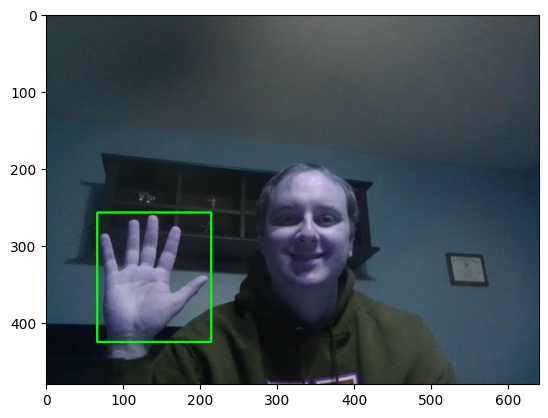

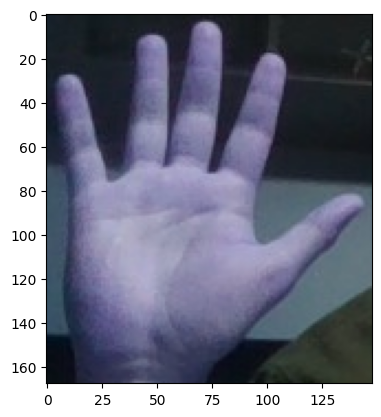

In [6]:
frame = cv2.imread("ExampleData/Example.jpg")

frame, cutFrame = findHand(frame, 10, hands)

if cutFrame is not None:
    if cutFrame.shape[0] != 0 and cutFrame.shape[1] != 0:
        plt.imshow(frame)
        plt.show()
        plt.imshow(cutFrame)
        plt.show()

# Part 2: CNN Usage

With this working, we can now take these mediapipe cutouts and use them to predict controller inputs
Thankfully we already have a custom trained model that we developed ourselves that can do this, we just have to load it in

## If you want to see more on how the model was trained or how we created our own data for training, we suggest you look at DataGather.py and trainCustom.py

In [7]:
import torch.nn as nn

# here is our model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))

        self.finalPool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(128, 6))  # 6 classes: 1, 2, 3, 4, 5, 6

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.finalPool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
# helps with converting our data to tensors
import torch

# helps us convert our captures into the format we need
from PIL import Image

import numpy as np

# use this to translate model outputs to keypresses
from pynput.keyboard import Key, Controller

In [9]:
# use this to convert our image to grayscale and preprocess
def convertImage(frame):
    # take the array, turn it into an image, grayscale it, and resize it
    frame = Image.fromarray(frame)
    image = frame.convert('L')
    image = image.resize((128, 128))
    
    # turn it into an array and normalize it
    image = np.array(image)
    
    image = image.astype(np.float32) / 255.0
    
    return image

# use this to predict our hands with the model
def predict_hand(cut_frame, model):
    
    # preprocess image
    image = convertImage(cut_frame)

    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=0)

    image = torch.tensor(image, dtype=torch.float32)

    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)  # Get the class with the highest probability

    return predicted.item()  # Return the predicted class

Now it's understandable that it might be difficult to imagine what the model sees when you use it. After all, if we just cut out our hands, which can produce a variable size image, then the model is going to have problems, that's why we trim and cut up the image. Below, we can see that process to the hand you gave us earlier:

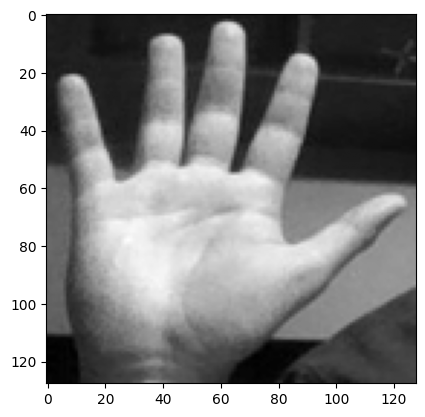

In [10]:
# take your image, convert it to grayscale, reshape it to 128x128, normalize it, and finally show it off
image = convertImage(cutFrame)

plt.imshow(image, cmap='gray')
plt.show()

Before we move on to our final step of trying to use the model to simulate a controller, we need to handle potential jitteryness from the model. Little differences on how you hand looks could possibly give bad readings and make inputs off. So we will be using a little bit of a rolling average to keep it somewhat consistent

In [11]:
class smoothInput:
    def __init__(self, size):
        self.size = size
        self.inputs = []
    
    def append(self, input):
        if len(self.inputs) >= self.size:
            self.inputs.pop(0)
        
        self.inputs.append(input)
    
    # when we need an input, get the input with the most amount
    def getInput(self):
        highestCount = 0
        count = 0
        for i in range(6):
            numCount = self.inputs.count(i)
            if numCount > count:
                highestCount = i
                count = numCount
            
            # if this count happens to be greater than half of the size, it is the default greatest
            if numCount >= len(self.inputs)/2:
                highestCount = i
                break
        
        return highestCount

# Part 3: Demonstration

With all of that complete, there is only one thing left to do, that is to try out the model

We should show what inputs are available. You should try to make one of 6 different hand signs. Thumbs up, Thumbs down, Point Down (back of hand facing camera), Point left (right hand), Point right (left hand), Point up (palm facing camera)

### NOTE: The point Left and Right images might look backwards, but this is how CV2 captures images. When you use the model, point in the direction that is logical. If you want to go right, point in the right direction with your left hand, and vice-versa

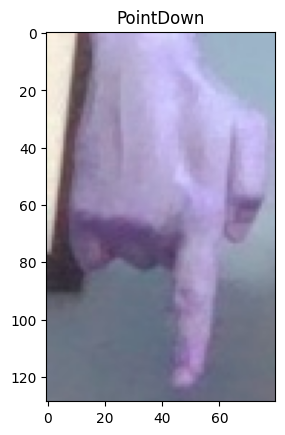

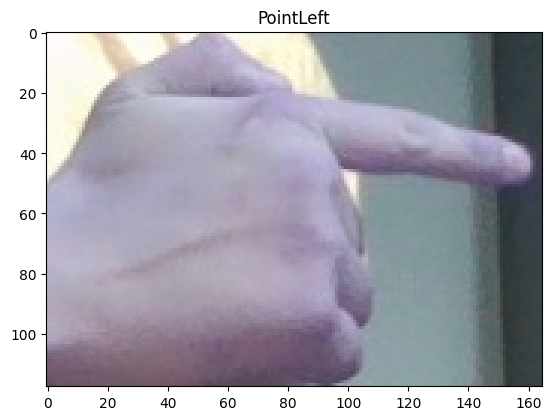

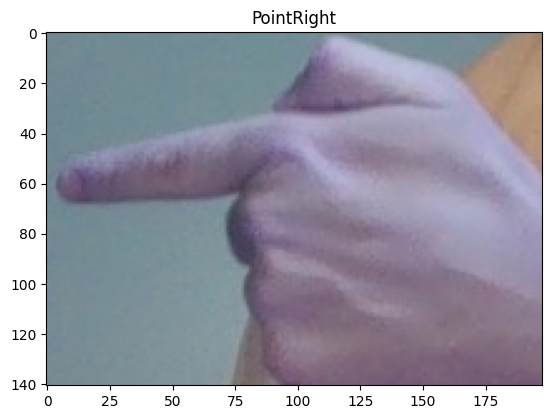

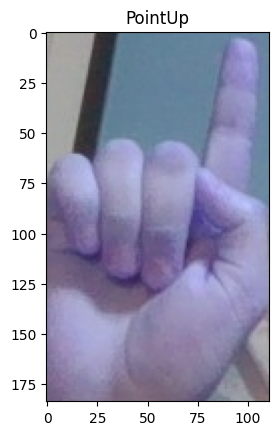

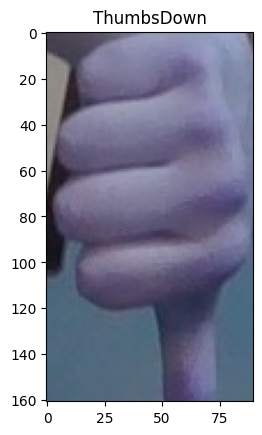

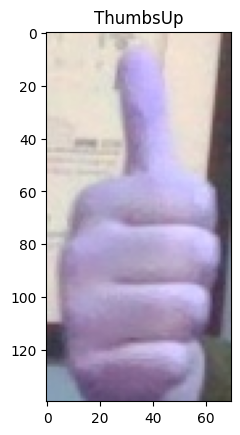

In [12]:
images = ["PointDown", "PointLeft", "PointRight", "PointUp", "ThumbsDown", "ThumbsUp"]

for image in images:
    savedImg = cv2.imread("ExampleData/{}.jpg".format(image))
    
    plt.imshow(savedImg)
    plt.title(image)
    plt.show()

Simply put, these hand gestures represent different possible inputs we can put into our simulated controller
## As a Reference, these are the following inputs we are targeting for our controller
### ThumbsUp = A
### ThumbsDown = B
### PointDir = DPAD

In [13]:
# Let's load our model now
model = CNN()
model.load_state_dict(torch.load("custom_model.pth"))

model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (finalPool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): 

Let's evaluate its accuracy from training, we will load up already preprocessed images that only need to be normalized before putting them into the model. This should show us how effective our model already is based on training

### Do keep in mind...
Despite having a very thorough dataset, the model can run into problems. To give it the best chance, ensure you have ample lighting and that your hands are in a clear, unobstructed view when using the model.

In [15]:
import os

# Load dataset
print("Loading the dataset")

#0 = a, 1 = b, 2 = down, 3 = left, 4 = right, 5 = up
directories = ['a', 'b', 'down', 'left', 'right', 'up']

images = []
imageLabels = []
for i in range(len(directories)):
    for fileName in os.listdir("HandData/{}".format(directories[i])):
        image = Image.open(os.path.join("HandData/{}".format(directories[i]), fileName))
        image = np.array(image)
        
        image = image.astype(np.float32) / 255.0

        image = np.expand_dims(image, axis=0)
        image = np.expand_dims(image, axis=0)

        image = torch.tensor(image, dtype=torch.float32)
        
        images.append(image)
        
        imageLabels.append(i)

print("Evaluating the Model")
totalCount = len(imageLabels)
count = 0

for i in range(len(images)):
    output = model(images[i])
    _, predicted = torch.max(output, 1)
    prediction = predicted.item()
    
    if prediction == imageLabels[i]:
        count += 1


print("ACCURACY: {}".format(count/totalCount))    

Loading the dataset
Evaluating the Model
ACCURACY: 0.9709273182957393


Now that we have evaluated the accuracy, let's use the model proper

### NOTE: If you don't have a camera or the model is having troubles detecting your gestures, use the ALT cell below

Make sure you have a simple game or even a text editor on the side, that way you can see the model work. Once you start the model, click inside the window to focus it so that the model's outputs go to the window

In [16]:
# Here is our defined keys for each of the model's outputs, feel free to adjust them as needed based on the task, game, or other program at hand.
# In this case, the default controls here ['x', 'z', down, left, right, up] is the input setup to target an emulator's, RetroArch, default NES controls
input0 = 'x'
input1 = 'z'
input2 = Key.down
input3 = Key.left
input4 = Key.right
input5 = Key.up

outputs = [input0, input1, input2, input3, input4, input5]

# adjust this as well to impact the balance between jittery and responsive on the controls.
# The higher the number the more stable the outputs, but you can see delay. We strongly don't recommend anything higher than 10
smoothFactor = 1

In [20]:
# once again, start our captures
cap = videoCapture()

# create a smooth input
smooth = smoothInput(smoothFactor)

# define our keyboard
keyboard = Controller()

# here is the margin value, we recommend keeping it at 10
margin = 10

currentOutput = 'x'

# keep running the algorithm until we cancel it
while True:
    ret, frame = cap.read()
    
    # did the camera stop working? End it
    if not ret:
        break

    # Find the hand and get the cropped frame
    frame, cutFrame = findHand(frame, margin, hands)
    
    if cutFrame is not None:
        if cutFrame.shape[0] != 0 and cutFrame.shape[1] != 0:
            # Display the cropped frame
            cv2.imshow("cutFrame", cutFrame)

            # Predict the class of the hand gesture
            predicted_class = predict_hand(cutFrame, model)
            
            smooth.append(predicted_class)
            
            actualOutput = smooth.getInput()
            
            print(f"Predicted Class: {predicted_class}, Smoothed Class: {actualOutput}")
            
            actualOutput = outputs[actualOutput]            
            
            if actualOutput != currentOutput:
                keyboard.release(currentOutput)
                keyboard.press(actualOutput)
                
                currentOutput = actualOutput
            
            # the predicted class can then be translated into one of 6 inputs
            if actualOutput == 0:
                keyboard.press('x')
            elif actualOutput == 1:
                keyboard.press('z')
            elif actualOutput == 2:
                keyboard.press(Key.down)
            elif actualOutput == 3:
                keyboard.press(Key.left)
            elif actualOutput == 4:
                keyboard.press(Key.right)
            else:
                keyboard.press(Key.up)
            
    # Display the frame
    cv2.imshow("frame", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

endCapture(cap)

Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Cl

# Results
Hopefully the model behaved for you, but you should have quickly noticed that while such a solution can be feasible, nothing quite replaces a proper controller or keyboard :)

## ALT Option: No camera or model misbehaving
Below, we have a demonstration of how the model works in optimal conditions. We will be using the same set of images in the "ExampleData" Folder that you saw earlier above, to demonstrate the functionality of the model.

In [21]:
# step one, grab our images
ThumbsUp = cv2.imread("ExampleData/ThumbsUp.jpg")
ThumbsDown = cv2.imread("ExampleData/ThumbsDown.jpg")

PointDown = cv2.imread("ExampleData/PointDown.jpg")
PointLeft = cv2.imread("ExampleData/PointLeft.jpg")
PointRight = cv2.imread("ExampleData/PointRight.jpg")
PointUp = cv2.imread("ExampleData/PointUp.jpg")

# run predictions
TUp = predict_hand(ThumbsUp, model)
TD = predict_hand(ThumbsDown, model)
D = predict_hand(PointDown, model)
L = predict_hand(PointLeft, model)
R = predict_hand(PointRight, model)
Up = predict_hand(PointUp, model)

# output the results, you should see it print out 0, 1, 2, 3, 4, 5 in that order
print("Thumbs Up Prediction (0, is correct): {}".format(TUp))
print("Thumbs Down Prediction (1, is correct): {}".format(TD))
print("Point Down Prediction (2, is correct): {}".format(D))
print("Point Left Prediction (3, is correct): {}".format(L))
print("Point Right Prediction (4, is correct): {}".format(R))
print("Point Up Prediction (5, is correct): {}".format(Up))

Thumbs Up Prediction (0, is correct): 0
Thumbs Down Prediction (1, is correct): 1
Point Down Prediction (2, is correct): 2
Point Left Prediction (3, is correct): 3
Point Right Prediction (4, is correct): 4
Point Up Prediction (5, is correct): 5


With these confirmed images having good outputs, we can use them, just like with our hands in the traditional sense, to act as controls. Run the cell below with a text editor like notepad, and you should see the model type something out

In [23]:
# just to give you enough time to click on another window that is appropriate for input
import time
time.sleep(3)

keyboard = Controller()

input0 = 'L'
input1 = 'o'
input2 = 'k'
input3 = 's'
input4 = 'G'
input5 = 'd'

outputs = [input0, input1, input2, input3, input4, input5]

images = [ThumbsUp, ThumbsDown, PointDown, PointLeft, PointRight, PointUp]

sequence = [0, 1, 1, 2, 3, 4, 1, 1, 5]

for num in sequence:
    output = predict_hand(images[num], model)
    keyboard.tap(outputs[output])

# FURTHER CONTENT

While we have completed our project here, there is still more to be seen. We have experimented with other models beyond our custom one. If you want to see it and recordings of our custom model working, we recommend you check out the "Recordings" Folder in this project.

# AI Acknowledgement

As was said before, we are allowed to use Generative AI as long as we document to what extent we used it

For this project, we use ChatGPT to help us improve our overall model's performance. Our original model was only outputting around 40% accuracy despite dozens of training cycles. We asked the AI what we could do to improve the model's performance and it said we should change our convolutional layers to include more functionality like this:

### self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))

This is in comparison of our layers originally being:

### self.conv1 = nn.Conv2d(1, 32, 3, padding=1)

### Old Versions Folder

In the trainCustomEdgeDetection.py, we used AI to add some edge detection and how to properly implement that. For example, this code (edge_image = cv2.Canny(image, threshold1=100, threshold2=100)) came from AI. In the model architectures, AI gave some suggestions to improve the model. For example, trying different optimizers like Adam or SGD. Whenever there was an error that did not make sense, we use AI to understand what this error is about and how to resolve it.